In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [81]:
class ConvolutionLayer:
    def __init__(self, kernel_num, kernel_size):
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size) / (kernel_size ** 2)

    def patches_generator(self, image):
        image_h, image_w = image.shape
        self.image = image
        #fxf filter is h-f+1 for height and w-f+1 for width
        for h in range(image_h - self.kernel_size + 1):
            for w in range(image_w - self.kernel_size + 1):
                patch = image[h:(h + self.kernel_size), w:(w + self.kernel_size)]
                yield patch, h, w

    def forward_prop(self, image):
        image_h, image_w = image.shape

        convolution_output = np.zeros((image_h - self.kernel_size + 1, image_w - self.kernel_size + 1, self.kernel_num))

        for patch, h, w in self.patches_generator(image):
            convolution_output[h, w] = np.sum(patch * self.kernels, axis=(1, 2))

        return convolution_output

    def back_prop(self, dE_dY, alpha):
        #dE_dY comes from the max pooling layer.
        dE_dk = np.zeros(self.kernels.shape)
        for patch, h, w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                dE_dk[f] += patch * dE_dY[h, w, f]

        self.kernels -= alpha * dE_dk
        return dE_dk

In [82]:
class MaxPoolingLayer:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def patches_generator(self, image):
        output_h = image.shape[0] // self.kernel_size
        output_w = image.shape[1] // self.kernel_size
        self.image = image

        for h in range(output_h):
            for w in range(output_w):
                patch = image[(h * self.kernel_size):(h * self.kernel_size + self.kernel_size),
                        (w * self.kernel_size):(w * self.kernel_size + self.kernel_size)]
                yield patch, h, w

    def forward_prop(self, image):
        image_h, image_w, num_kernels = image.shape
        max_pooling_output = np.zeros((image_h // self.kernel_size, image_w // self.kernel_size, num_kernels))
        for patch, h, w in self.patches_generator(image):
            max_pooling_output[h, w] = np.amax(patch, axis=(0, 1))
        return max_pooling_output

    def back_prop(self, dE_dY):
        #dE_dY comes from softmax
        #no weights to update
        #output is needed to update the weights of the convolutional layer
        dE_dk = np.zeros(self.image.shape)
        for patch, h, w in self.patches_generator(self.image):
            image_h, image_w, num_kernels = patch.shape
            max_val = np.amax(patch, axis=(0, 1))

            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        if patch[idx_h, idx_w, idx_k] == max_val[idx_k]:
                            dE_dk[h * self.kernel_size + idx_h, w * self.kernel_size + idx_w, idx_k] = dE_dY[
                                h, w, idx_k]
            return dE_dk

In [83]:
class SoftmaxLayer:
    def __init__(self, input_units, output_units):
        self.weight = np.random.randn(input_units, output_units) / input_units
        self.bias = np.zeros(output_units)

    def forward_prop(self, image):
        self.original_shape = image.shape
        image_flattened = image.flatten()
        self.flattened_input = image_flattened
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    def back_prop(self, dE_dY, alpha):
        for i, gradient in enumerate(dE_dY):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            dY_dZ = -transformation_eq[i] * transformation_eq / (S_total ** 2)
            dY_dZ[i] = transformation_eq[i] * (S_total - transformation_eq[i]) / (S_total ** 2)

            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            dE_dZ = gradient * dY_dZ

            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            self.weight -= alpha * dE_dw
            self.bias -= alpha * dE_db

            return dE_dX.reshape(self.original_shape)

In [84]:
def CNN_forward(image, label, layers):
    output = image / 255.
    for layer in layers:
        output = layer.forward_prop(output)

    # print(f"out sofmax shape: {output}")
    # print(f"argmax of softmax: {np.argmax(output)}")
    # (cross-entropy)
    loss = -np.log(output[label])
    accuracy = 1 if np.argmax(output) == label else 0
    # print(f"input digit: {np.argmax(output)} and predicted: {label} is {accuracy}")
    return output, loss, accuracy

In [85]:
def CNN_backprop(gradient, layers, alpha=0.05):
    grad_back = gradient
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back

In [86]:
def CNN_training(image, label, layers, alpha=0.05):
    output, loss, accuracy = CNN_forward(image, label, layers)
    gradient = np.zeros(10)
    gradient[label] = -1 / output[label]
    gradient_back = CNN_backprop(gradient, layers, alpha)
    return loss, accuracy

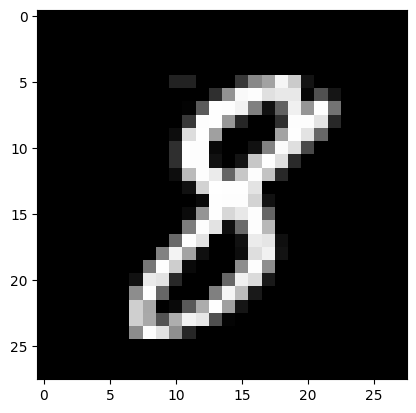

(28, 28)


In [87]:
df_train = pd.read_csv('train.csv')
img = df_train.iloc[20, :].values[1:]
img = np.reshape(img, (28, 28))
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)
# plt.savefig('images/original_image.png', format='png', dpi=1200)

In [88]:
my_conv = ConvolutionLayer(32, 3)
output = my_conv.forward_prop(img)
print(output.shape)

(26, 26, 32)


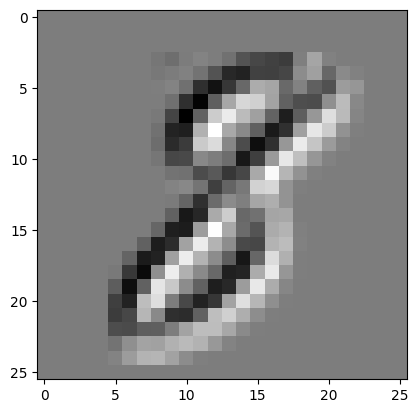

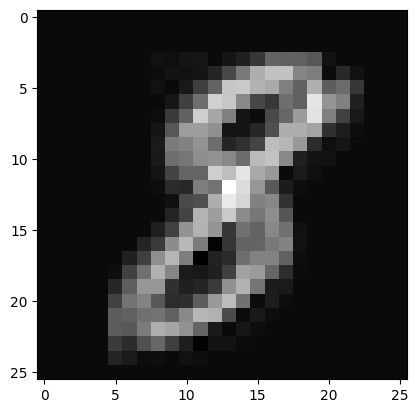

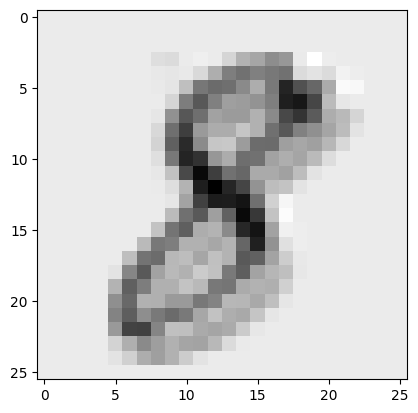

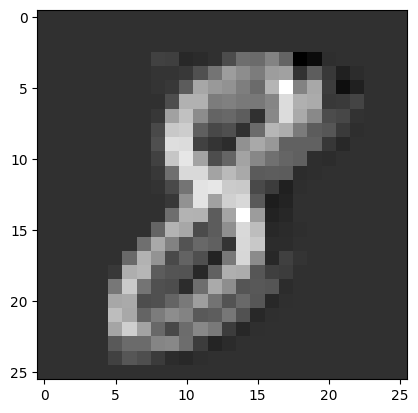

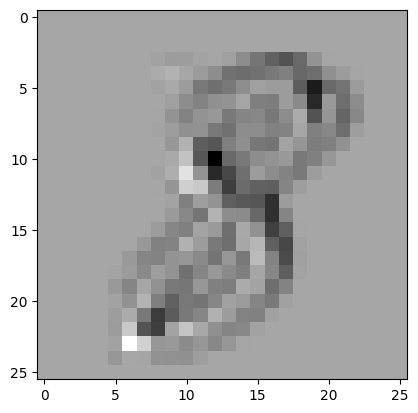

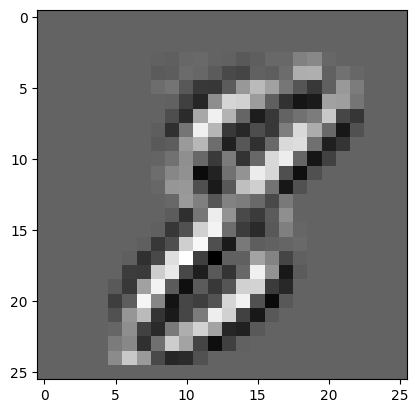

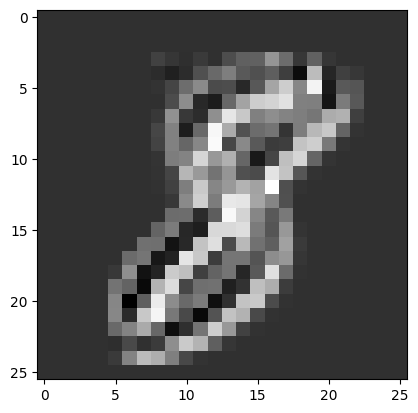

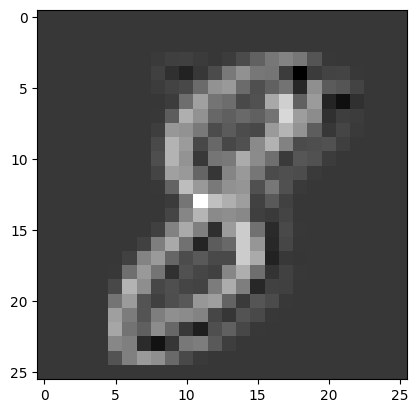

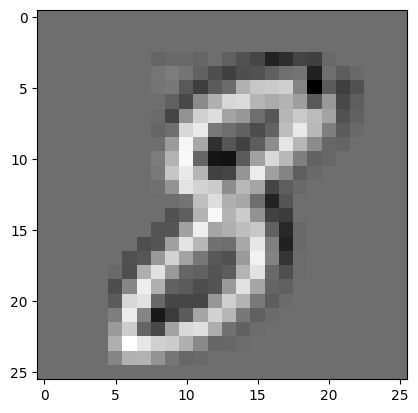

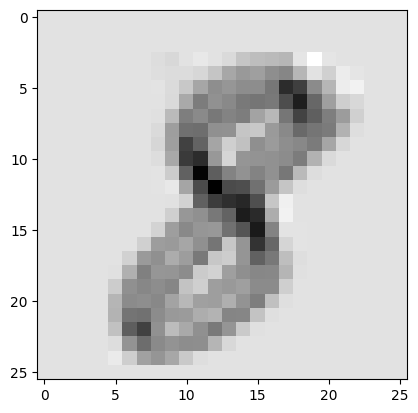

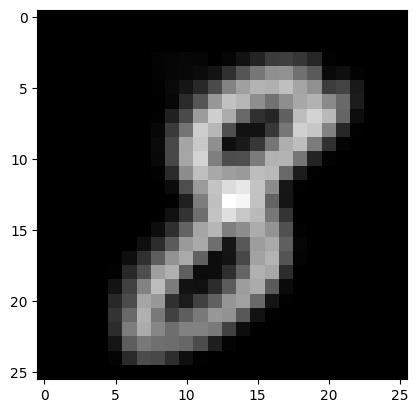

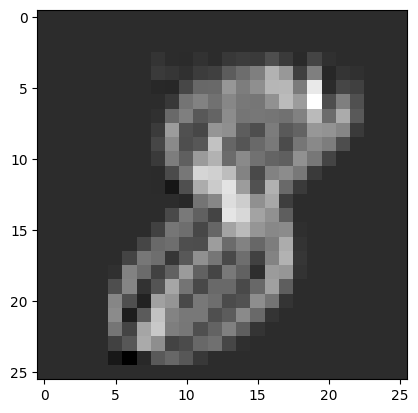

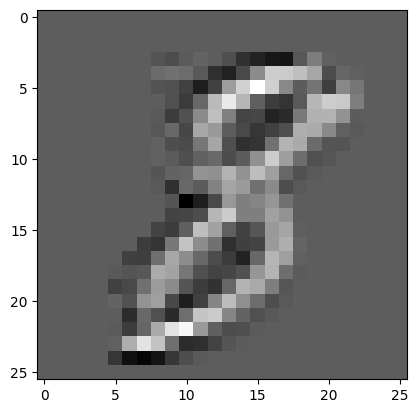

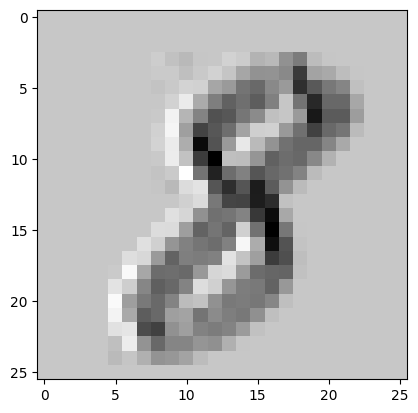

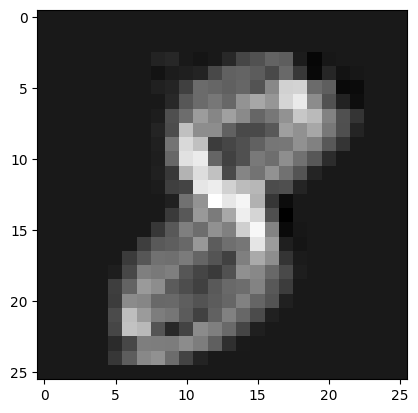

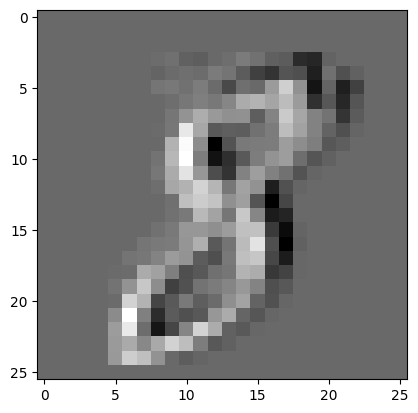

In [89]:
for i in range(16):
    plt.imshow(output[:, :, i], cmap='gray')
    plt.show()
    # plt.savefig('images/image_convolved.png', format='png', dpi=1200)

In [90]:
my_pool = MaxPoolingLayer(2)
output_pool = my_pool.forward_prop(output)
print(output_pool.shape)

(13, 13, 32)


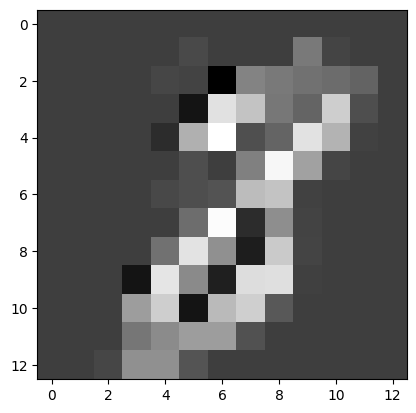

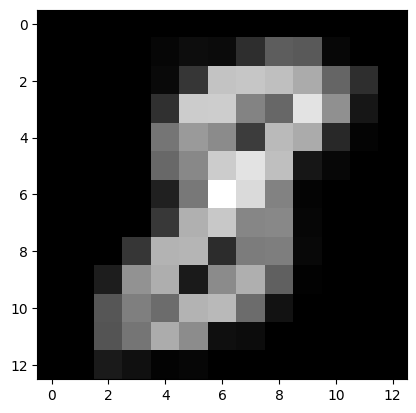

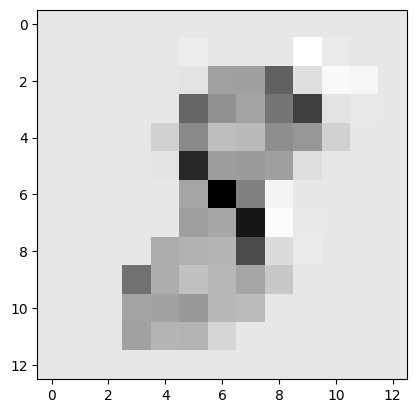

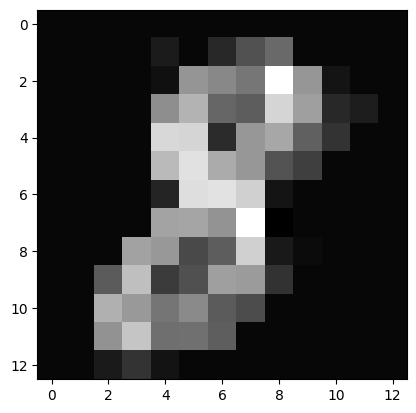

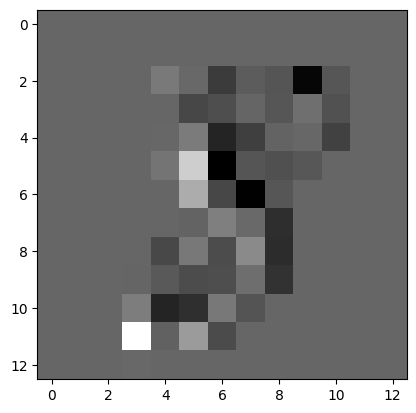

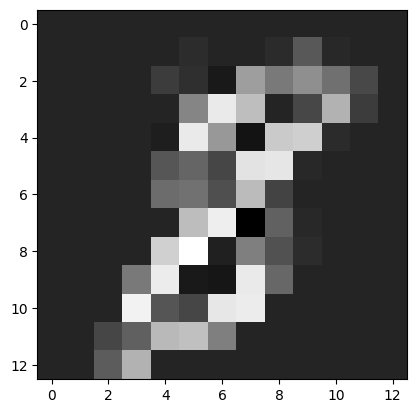

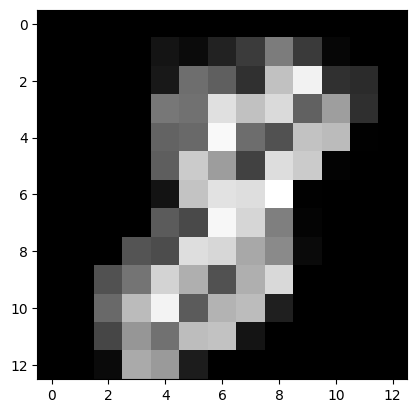

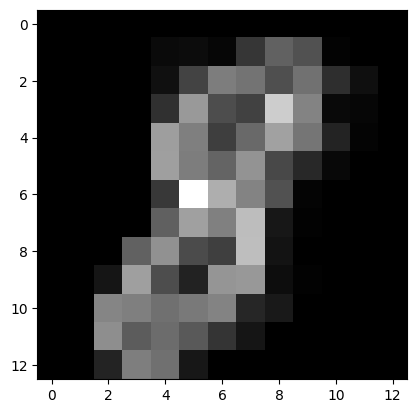

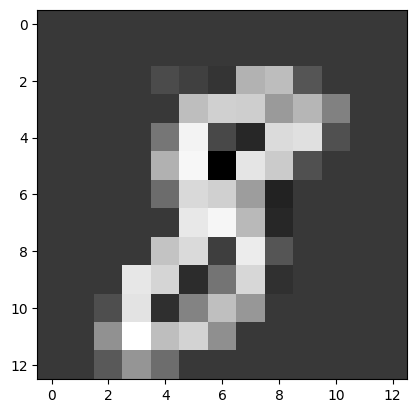

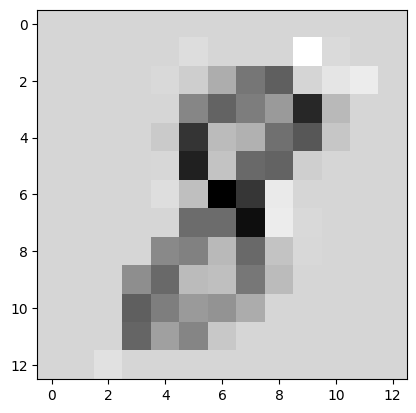

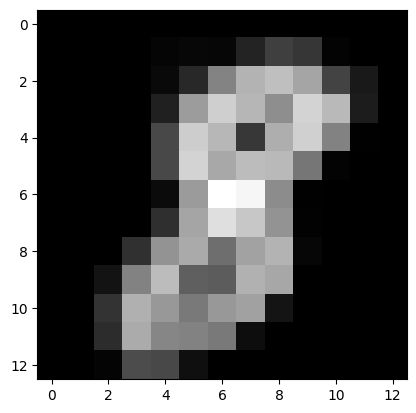

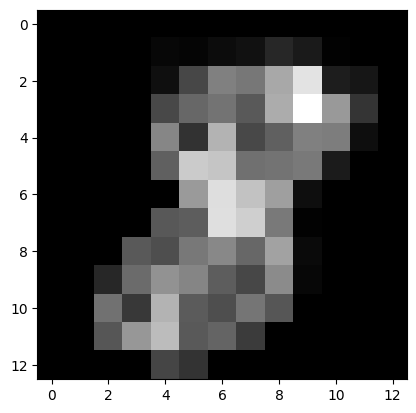

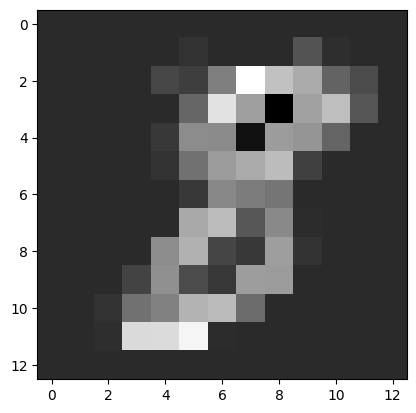

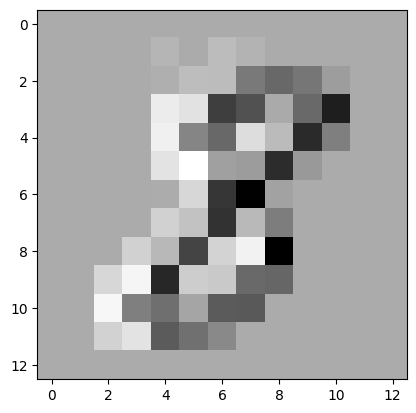

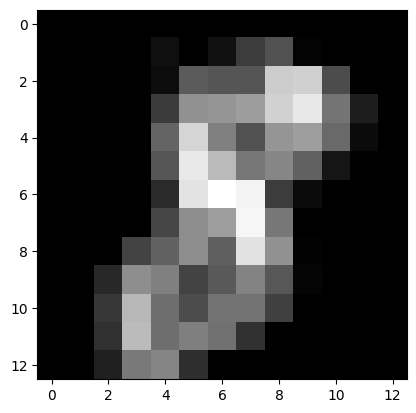

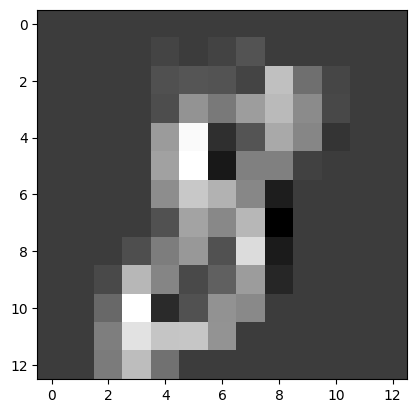

In [91]:
for i in range(16):
    plt.imshow(output_pool[:, :, i], cmap='gray')
    plt.show()

Epoch 1 ->
Step 1. For the last 100 steps: average loss 0.0, accuracy 0
Step 101. For the last 100 steps: average loss 1.8261524576538877, accuracy 46
Step 201. For the last 100 steps: average loss 1.0649793088465436, accuracy 67
Step 301. For the last 100 steps: average loss 0.8539477489847223, accuracy 70
Step 401. For the last 100 steps: average loss 0.690012230361637, accuracy 76
Step 501. For the last 100 steps: average loss 0.5818961813897585, accuracy 81
Step 601. For the last 100 steps: average loss 0.6991138578127004, accuracy 81
Step 701. For the last 100 steps: average loss 0.7389212004119675, accuracy 73
Step 801. For the last 100 steps: average loss 0.5794940780500275, accuracy 84
Step 901. For the last 100 steps: average loss 0.43446039890878296, accuracy 87
Step 1001. For the last 100 steps: average loss 0.5771344728063674, accuracy 84
Step 1101. For the last 100 steps: average loss 0.6687875047809532, accuracy 78
Step 1201. For the last 100 steps: average loss 0.8460697

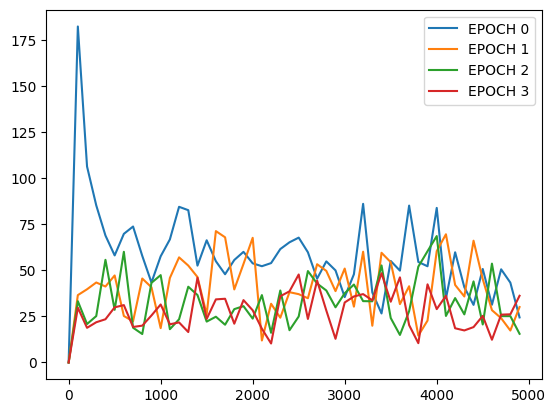

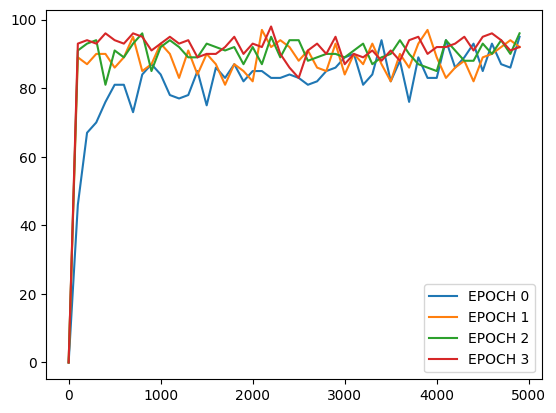

In [92]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[:5000]
y_train = y_train[:5000]

layers = [
    ConvolutionLayer(16, 3),
    MaxPoolingLayer(2),
    SoftmaxLayer(13 * 13 * 16, 10)
]
xs_plot = []
ys_loss_plot = []
ys_acc_plot = []
labels = []
for epoch in range(4):
    print('Epoch {} ->'.format(epoch + 1))
    # Shuffle training data
    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    # Training the CNN
    loss = 0
    accuracy = 0
    xs_loss = []
    ys_loss = []
    xs_acc = []
    ys_acc = []
    for i, (image, label) in enumerate(zip(X_train, y_train)):
        if i % 100 == 0:  # Every 100 examples
            print(
                "Step {}. For the last 100 steps: average loss {}, accuracy {}".format(i + 1, loss / 100, accuracy))
            xs_loss.append(i)
            ys_loss.append(loss)
            xs_acc.append(i)
            ys_acc.append(accuracy)
            loss = 0
            accuracy = 0
        loss_1, accuracy_1 = CNN_training(image, label, layers)
        loss += loss_1
        accuracy += accuracy_1
    if epoch == 1:
        xs_plot = xs_loss
    ys_loss_plot.append(ys_loss)
    ys_acc_plot.append(ys_acc)
    labels.append(f"EPOCH {epoch}")
    # plt.plot(xs_loss, ys_loss)
    # plt.title(f"LOSS on {epoch} epoch")
    # plt.show()
    # plt.plot(xs_acc, ys_acc)
    # plt.title(f"Accuracy on {epoch} epoch")
    # plt.show()
for i in range(len(ys_loss_plot)):
    plt.plot(xs_plot, ys_loss_plot[i])
plt.legend(labels)
plt.show()
for i in range(len(ys_acc_plot)):
    plt.plot(xs_plot, ys_acc_plot[i])
plt.legend(labels)
plt.show()